## SLネットモデル

学習は全て白手番で進行させ（黒手番のデータは全て反転させる）、予測の実行の際には黒手番の場合には盤面を反転させて入力させ、出力は挿す位置ゆえそのまま使用すればいい

In [1]:
import pandas as pd
import numpy as np
import pickle
np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_rows', 500)

In [2]:
  EMPTY=0
  WHITE=1
  BLACK=-1
  DRAW=2
  ERROR=-999
  EDGE_PAD=-999
  SQUARE_NUM=64
  SIDES_NUM=8
  CHANGE_COLOR=-1
  UP=[0,1]
  UPPER_RIGHT=[1,1]
  RIGHT=[1,0]
  LOWER_RIGHT=[1,-1]
  LOW=[0,-1]
  LOWER_LEFT=[-1,-1]
  LEFT=[-1,0]
  UPPER_LEFT=[-1,1] 
  ALL_VECTORS=[[-1,0],[-1,1],[0,1],[1,1],[1,0],[1,-1],[0,-1],[-1,-1]]
  VECTOR_NUM = 8
  INITIAL_REVERSIBLE_STONE_NUMBER_LIST=[0,0,0,0,0,0,0,0]
  INITIAL_WHITE_PLACES=[27,36]
  INITIAL_BLACK_PLACES=[28,35]

In [3]:
import copy

import numpy as np


class ReversiPackages(object):
    '''
    This class is packages used in reversi_processor.py
    '''

    def __init__(self, board=None, options=None, display_board=True):

        '''
        Initialize class parameters.
        
        Args:
            display_board(boolean):
                False -> not display board
                True -> display board

            board(list):
                shape = (total_square_num=64, 1)
                instructions: board state
                              empty(no stone) -> 0
                              white stone -> 1
                              brack stone -> -1

            options(toml):
                global parameters.
        '''
        # self.__board is game board
#         if board == None or board ==[]:
#             self.__board = []

#             # make empty board.
#             for index in range(SQUARE_NUM):
#                 self.__board.append(EMPTY)

#             # set initial 2 white stones
#             for initial_white_place in INITIAL_WHITE_PLACES:
#                 self.__board[initial_white_place] = WHITE

#             # set initial 2 black stones
#             for initial_black_place in INITIAL_BLACK_PLACES:
#                 self.__board[initial_black_place] = BLACK

#         else:
#             self.__board = board
        self.__board = board

        # self.__winner flag is used when checking __winner
        self.__winner = None

        # self.__reversible_stone_number_dict: dictionary
        #   keys: empty(no stone) index in game board
        #   values: list of how many stones reversed when putting stone there for all 8 directions
        self.__reversible_stone_number_dict = {}

        self.__display_board = display_board
        # make class variables for displaying board
        if self.__display_board:




            # number board (1 ~ 64) for displaying
            self.__index_board_for_displaying = []
            for index in range(SQUARE_NUM):
                self.__index_board_for_displaying.append(index + 1)

    def _get_index_in_padded_board(self, index_in_1d_board):
        '''
        This function get index in padded 8x8 board from one dimension board index
        Args board:
        Returns:

        '''
        return index_in_1d_board // SIDES_NUM + 1, index_in_1d_board % SIDES_NUM + 1

    def _get_reversible_stone_num_loop(self, base_vector, unit_vector, index, padded_board, stone_color, counter):
        '''
         this function get the if the stone is reversible in the index and vector,
         and also get the number of reversible stone

        Args:
            base_vector(list):
                shape = (2,1)
                instruction: base vector

            unit_vector(list):
                shape = (2,1)
                instruction: put unit vector of all direction

            index(int):
                shape = ()
                instruction: index of the empty place in one dimension array which length is 64.

            padded_board(numpy error):
                shape = (10,10)
                instruction: padded Reversi board

            stone_color(int):
                stone's color
                white -> 1
                black -> -1

        Return:
             is_reversible(boolean):
                shape = ()
                instruction:
                    true -> the stone is reversible in this index and vector
                    false -> the stone is not reversible in this index and vector

            count(int):
                shape = ()
                instruction: the number of reversible stone

        '''
        # counter counts the number of reversible stone
        counter += 1

        # status is the status in focused place of this function
        status = padded_board[self._get_index_in_padded_board(index)[0] +
                              base_vector[0]][self._get_index_in_padded_board(index)[1] + base_vector[1]]

        # if status is different to the stone_color, use _get_reversible_stone_num_loop to conclude the count
        if status == CHANGE_COLOR * stone_color:
            base_vector[0] += unit_vector[0]
            base_vector[1] += unit_vector[1]
            is_reversible, counter = \
                self._get_reversible_stone_num_loop(base_vector, unit_vector, index, padded_board, stone_color, counter)

        # if status is same as the stone_color, return True and counter
        elif status == stone_color:
            is_reversible = True

        # if status is empty or edge, return False to is_reversible
        else:
            is_reversible = False

        return is_reversible, counter

    def _get_reversible_stone_num(self, unit_vector, index, padded_board, stone_color):
        '''
        this function get the if the stone is reversible in the index and vector,
         and also get the number of reversible stone

        Args:
            unit_vector(list):
                shape = (2,1)
                instruction = put unit vector of all direction

            index(int):
                shape = ()
                instruction: index of the empty place in one dimension array which length is 64.

            padded_board(numpy array):
                shape = (10,10)
                instruction: padded Reversi board

            stone_color(int):
                stone's color
                white -> 1
                black -> -1

        Return:
             is_reversible(boolean):
                shape = ()
                instruction:
                    true -> the stone is reversible in this index and vector
                    false -> the stone is not reversible in this index and vector
        '''
        # counter counts the number of reversible stone
        counter = 1

        # status is the status in focused place of this function
        status = padded_board[self._get_index_in_padded_board(index)[0] + 2 *
                              unit_vector[0]][self._get_index_in_padded_board(index)[1] + 2 * unit_vector[1]]

        # if status is different to the stone_color, use _get_reversible_stone_num_loop to conclude the count
        if status == CHANGE_COLOR * stone_color:
            base_vector = [0, 0]
            base_vector[0] = 3 * unit_vector[0]
            base_vector[1] = 3 * unit_vector[1]
            is_reversible, counter = \
                self._get_reversible_stone_num_loop(base_vector, unit_vector, index, padded_board, stone_color, counter)
        # if status is same as the stone_color, return True and counter
        elif status == stone_color:
            is_reversible = True

        # if status is empty or edge, return False to is_reversible
        else:
            is_reversible = False

        return is_reversible, counter

    def get_stone_putable_pos(self, stone_color):

        '''
        This function get stone putable position from player's stone_color

        Args:
            stone_color(int):
                shape = ()
                instructions:
                              white -> 1
                              brack -> -1

        Returns:
            putable_pos(list):
                shape = (the number of stone putable position)
                instructions:
                    get stone putable position list

        '''

        # change the shape of board list to 2 dimension numpy array
        board_8x8 = np.array(self.__board).reshape(SIDES_NUM, SIDES_NUM)

        # Pad the edges
        vertical_edge_pad = np.full((1, SIDES_NUM), EDGE_PAD)
        horizontal_edge_pad = np.full((SIDES_NUM + 2, 1), EDGE_PAD)
        vertical_padded_board = np.vstack((vertical_edge_pad, board_8x8, vertical_edge_pad))
        padded_board = np.hstack((horizontal_edge_pad, vertical_padded_board, horizontal_edge_pad))

        empty_pos_index_list = []
        for index in range(SQUARE_NUM):
            if self.__board[index] == EMPTY:
                empty_pos_index_list.append(index)

        # putable_pos_set is a set of stone putable place
        putable_pos_set = set()

        # for every empty place, validate if the stone is putable
        for empty_pos_index in empty_pos_index_list:
            reversible_stone_number_list = copy.deepcopy(INITIAL_REVERSIBLE_STONE_NUMBER_LIST)

            # for every direction from the index, validate if there is the reversible stone
            for index in range(VECTOR_NUM):
                vector = ALL_VECTORS[index]

                # if the place next to index place have the stone which color is different from the player stone color,
                if padded_board[self._get_index_in_padded_board(empty_pos_index)[0] +
                                vector[0]][self._get_index_in_padded_board(empty_pos_index)[1] + vector[1]] == \
                       CHANGE_COLOR * stone_color:

                    # validate is the stone is reversible by _get_reversible_stone_num
                    is_reversible, counter = \
                        self._get_reversible_stone_num(vector, empty_pos_index, padded_board, stone_color)

                    # if there is reversible stones, save the vector and the number of stones in\
                    # reversible_stone_number_list and save the index in putable_pos_set
                    if is_reversible:
                        reversible_stone_number_list[index] = counter
                        putable_pos_set.add(empty_pos_index)

            # save the empty_pos_index and reversible_stone_number_list in reversible_stone_number_dict to use in\
            # reversing_stones function
            self.__reversible_stone_number_dict[empty_pos_index] = reversible_stone_number_list

        return list(putable_pos_set)

    def check_winner(self):

        '''
        This function check which player wins (black stone player of white stone player) or draw.
            if __winner is white, self.__winner <- 1
            if __winner is brack, self.__winner <- -1
            if draw, self.__winner <- 2
        '''

        sum_score = sum(self.__board)

        # if __winner is white, sum_score > 0
        if sum_score > 0:
            self.__winner = WHITE

        # if __winner is black, sum_score < 0
        elif sum_score < 0:
            self.__winner = BLACK

        # if draw, sum_score = 0
        else:
            self.__winner = DRAW

        return self.__winner

    def reversing_stones(self, putting_index, stone_color):

        '''
        This function reversing stones adapted to putting place.
        inserting reversed board information to self.__board.

        Args:
            putting_index(int):
                index where putting new stone

            stone_color(int):
                stone's color
                white -> 1
                black -> -1
        '''

        # putting new stone
        self.__board[putting_index] = stone_color

        # reversing stone for all 8 directions adapting to self.__reversible_stone_number_dict
        for index in range(VECTOR_NUM):
            vector = ALL_VECTORS[index]
            for i in range(self.__reversible_stone_number_dict[putting_index][index]):
                i += 1
                self.__board[putting_index + (SIDES_NUM * vector[0] + vector[1]) * i] *= \
                    CHANGE_COLOR

    def get_board_status(self, stone_color):
        putable_pos_list = self.get_stone_putable_pos(stone_color)
        board = copy.deepcopy(self.__board)
        for index in putable_pos_list:
            board[index] = 2
        return board


In [4]:
def get_stone_putable_pos(board, player):
    """
    get stone putable index from board state and player's stone color
    :param board: list(int)
        shape = (1,64)
    :param player:int
         -1 -> black
        1 -> white
    :return: stone_putable_pos: list(int)
    """
    reversi_packages = ReversiPackages(
        board=board,
        options=None
    )
    stone_putable_pos = reversi_packages.get_stone_putable_pos(player)
    return stone_putable_pos

### データの前処理

In [5]:
# データの読み込み
data = pd.read_csv('input/kihuFixed.txt', header=None)
data.shape

(6066495, 1)

In [6]:
data = data[0].str.split(' ', expand=True).drop([256834], axis=0)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5,3,W,59
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,5,W,57
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4,6,W,55
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4,7,W,53
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4,3,W,51


In [7]:
# 学習データと正解データを分離
data_x = data.iloc[:, :64].values
data_player = data[66]
data_y = data.iloc[:, 64:66].values

In [8]:
# 黒の石の2を-1に変換
data_x = data_x.astype('int')
data_x = np.where(data_x == 2, -1, data_x) # .reshape(-1, 1, 8, 8)

In [9]:
# player情報を1, -1に変換
def player_preprocessing(x):
    
    if x == 'B':
        x = -1
    elif x == 'W':
        x = 1 
    return x

data_player = data_player.map(player_preprocessing).values

In [10]:
# 正解データを作成
data_y = data_y.astype('int')
data_y = (data_y[:, 0] - 1) * 8 + data_y[:, 1] - 1

In [11]:
# 黒手番の時の盤面情報は反転させる
black_index = np.where(data_player == -1)[0]
data_x[black_index]  = data_x[black_index] * -1

In [12]:
# 置ける手のindexを取得
# putable_list = []
# for x in data_x:
#     putable_list.append(get_stone_putable_pos(x, 1))

# with open('input/putable_list.pkl', 'wb') as f:
#     pickle.dump(putable_list, f)
    
putable_list = pd.read_pickle('input/putable_list.pkl')

In [13]:
# 置ける場所のindexを1にマスクして他を0でうめたarrayを作成
np_pos = np.zeros((len(data), 64))

for i, putable in enumerate(putable_list[:10]):
    np_pos[i][putable] = 1
    
# board_info と putable　の2チャンネル情報を学習データにする
data_x = np.hstack([np_pos.reshape(-1, 1, 8, 8), data_x.reshape(-1, 1, 8, 8)])

del putable_list, np_pos, data

### 学習

In [14]:
# 2. DataLoderの作成

import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# 2.1 データを訓練とテストに分割
X_train, X_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=1/100, random_state=0)

# 2.2 データをPyTorchのTensorに変換
X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# 2.3 データとラベルをセットにしたDatasetを作成
X_train = TensorDataset(X_train, y_train)
X_test = TensorDataset(X_test, y_test)

# 2.4 データセットのミニバッチサイズを指定した、Dataloaderを作成
# Chainerのiterators.SerialIteratorと似ている
X_train = DataLoader(X_train, batch_size=1024, shuffle=True)
X_test = DataLoader(X_test, batch_size=1024, shuffle=False)

del data_x, data_y

In [15]:
from torch import nn
import torch.nn.functional as F

class CNNModel (nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
 
        self.conv1 = nn.Conv2d(2, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
 
        self.fc1 = nn.Linear(64*4*4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 64)
 
 
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, (2, 2))
 
        x = x.view(-1, 64*4*4)
 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        output = self.fc3(x)
        
        return output 

model = CNNModel()

In [16]:
# 誤差関数と最適化手法の設定

from torch import optim

# 誤差関数の設定
loss_fn = nn.CrossEntropyLoss()  # 変数名にはcriterionが使われることも多い

# 重みを学習する際の最適化手法の選択
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [17]:
def train(epoch):
    model.train()  # ネットワークを学習モードに切り替える
    running_loss = 0

    # データローダーから1ミニバッチずつ取り出して計算する
    for i, (data, targets) in enumerate(X_train):
      
        optimizer.zero_grad()  # 一度計算された勾配結果を0にリセット
        outputs = model(data)  # 入力dataをinputし、出力を求める
        loss = loss_fn(outputs, targets)  # 出力と訓練データの正解との誤差を求める
        loss.backward()  # 誤差のバックプロパゲーションを求める
        optimizer.step()  # バックプロパゲーションの値で重みを更新する
        running_loss += loss.item()
        
        if i % 200 == 0:
            print(loss.item())
        
    train_loss = running_loss / len(X_train)
    print("epoch{}：終了\n".format(epoch))
    return train_loss

In [18]:
def test():
    model.eval()  # ネットワークを推論モードに切り替える
    correct = 0
    running_loss = 0

    # データローダーから1ミニバッチずつ取り出して計算する
    with torch.no_grad():  # 微分は推論では必要ない
        for data, targets in X_test:

            outputs = model(data)  # 入力dataをinputし、出力を求める
            
            loss = loss_fn(outputs, targets)
            running_loss += loss.item()

            # 推論する
            _, predicted = torch.max(outputs.data, 1)  # 確率が最大のラベルを求める
            correct += predicted.eq(targets.data.view_as(predicted)).sum()  # 正解と一緒だったらカウントアップ

    # 正解率を出力
    data_num = len(X_test.dataset)  # データの総数
    val_acc = 100. * correct / data_num
    val_loss = running_loss / len(X_test)
    print('\nテストデータの正解率: {}/{} ({:.0f}%)\n'.format(correct,
                                                   data_num, 100. * correct / data_num))
    return val_acc, val_loss

In [19]:
# 学習なし
val_acc, val_loss = test()


テストデータの正解率: 10/60665 (0%)



In [20]:
# 学習と推論の実行
num_epochs = 3
loss_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss = train(epoch)
    val_acc, val_loss = test()
    
    # logging
    loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    torch.save(model.state_dict(), 'input/model_sl3.pt')

4.161727428436279
2.9160752296447754
2.694836139678955
2.626616954803467
2.4661753177642822
2.3550002574920654
2.3632025718688965
2.2677416801452637
2.2603232860565186
2.17612624168396
2.105865001678467
2.0896663665771484
2.0788180828094482
2.0662262439727783
2.0610852241516113
2.1337132453918457
2.0143041610717773
1.9722689390182495
2.027726888656616
2.035494089126587
1.9894181489944458
1.9938145875930786
2.0220119953155518
2.0295474529266357
1.9773099422454834
2.0209546089172363
1.9441553354263306
1.911303997039795
1.9652936458587646
1.946988821029663
epoch0：終了


テストデータの正解率: 23436/60665 (38%)

1.9447898864746094
1.943244218826294
1.9407496452331543
1.9310247898101807
1.9127625226974487
1.9360908269882202
1.9512724876403809
1.9821538925170898
2.0070974826812744
1.9736312627792358
1.8870307207107544
1.908768653869629
1.9707082509994507
1.8740181922912598
1.9232271909713745
1.881852388381958
1.8805873394012451
1.885301947593689
1.928767204284668
1.9431132078170776
1.9388513565063477
1.8

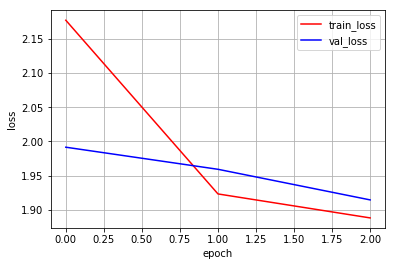

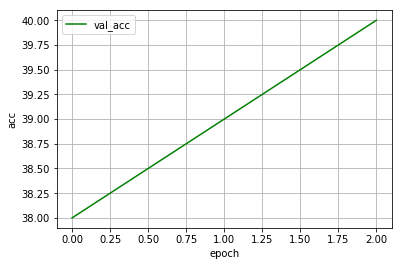

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot learning curve
plt.figure()
plt.plot(range(num_epochs), loss_list, 'r-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, 'b-', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), val_acc_list, 'g-', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.grid()

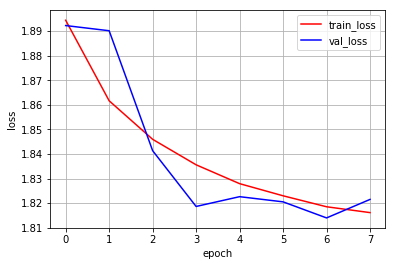

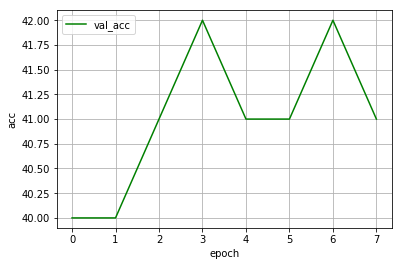

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot learning curve
plt.figure()
plt.plot(range(num_epochs), loss_list, 'r-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, 'b-', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), val_acc_list, 'g-', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.grid()

In [87]:

# 推論実行
model.eval()
sample_data = X_test[3].reshape(1, 1, 8, 8)

output = model(sample_data)  # 入力dataをinputし、出力を求める
_, predicted = torch.max(output.data, 1)  # 確率が最大のラベルを求める

print("予測結果は{}".format(predicted.item()))

予測結果は61
